In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
random.seed(2024)
np.random.seed(2024)
torch.manual_seed(2024)

## Helper functions

In [107]:
def scaler(col):
    return (col - np.min(col)) / (np.max(col) - np.min(col))


def vec_to_list(event_list):
    event_list = event_list.replace('[', '').replace(']', '').split()
    event_list = [int(float(x)) for x in event_list]
    return event_list


class Embedding(nn.Module):
    def __init__(self, embedding_dim, n_events=5):
        super().__init__()
        self.fc1 = nn.Linear(n_events, embedding_dim, bias=False)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(embedding_dim, embedding_dim, bias=False)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    

def preprocessing_steps(data):
    df = data.copy()
    df = df.drop(columns=['first_20_events', 'time_since_last_event', 'Unnamed: 1', 'downpayment_cleared', 'first_purchase',
                          'max_milestone', 'downpayment_received', 'account_activitation', 'customer_id'])
    
    df = df.dropna(axis=0)
    df_0, df_1 = df[df.order_ships == 0], df[df.order_ships == 1]
    df_0 = df_0.sample(n=len(df_1), random_state=2024)
    # df_1 = df_1.sample(n=(len(df_0)), replace=True)
    df_balanced = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

    # shuffle
    df_balanced = df_balanced.sample(frac=1)

    df_X = df_balanced.drop(columns='order_ships')
    target = df_balanced.order_ships
    ori_df = df.drop(columns='order_ships')
    ori_target = df.order_ships

    boolean_col = ['discover', 'one_more_journey', 'approved_credit', 'has_prospecting', 'has_pre_application']

    for col in boolean_col:
        df_X[col] = [1 if val == True else 0 for val in df_X[col]]
        ori_df[col] = [1 if val == True else 0 for val in ori_df[col]]


    return ori_df, ori_target, df_X, target


def preprocessing_steps_embedding(data):
    df = data.copy()
    df = df.drop(columns=['Unnamed: 1', 'downpayment_cleared', 'first_purchase',
                          'max_milestone', 'downpayment_received', 'account_activitation', 'customer_id'])
    df = df.astype({col: 'float' for col in df.columns[:-2]})
    
    df = df.dropna(axis=0)


    events = df['first_20_events'].apply(vec_to_list)
    events = torch.tensor(events.to_list()).float()
    events_emb = Embedding(5, 20)
    events = events_emb(events)
    event_pd = pd.DataFrame(events.detach().numpy(), columns=[f'event_id_{i}' for i in range(5)])

    time = df['time_since_last_event'].apply(vec_to_list)
    time = torch.tensor(time.to_list()).float()
    time_emb = Embedding(5, 20)
    time = time_emb(time)
    time_pd = pd.DataFrame(time.detach().numpy(), columns=[f'time_{i}' for i in range(5)])
    df = pd.concat([df, event_pd, time_pd], axis=1)
    df = df.drop(columns=['first_20_events', 'time_since_last_event'])


    df_0, df_1 = df[df.order_ships == 0], df[df.order_ships == 1]
    df_0 = df_0.sample(n=len(df_1), random_state=2024)
    # df_1 = df_1.sample(n=(len(df_0)), replace=True)
    df_balanced = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

    # shuffle
    df_balanced = df_balanced.sample(frac=1)

    df_X = df_balanced.drop(columns='order_ships')
    target = df_balanced.order_ships
    ori_df = df.drop(columns='order_ships')
    ori_target = df.order_ships

    boolean_col = ['discover', 'one_more_journey', 'approved_credit', 'has_prospecting', 'has_pre_application']

    for col in boolean_col:
        df_X[col] = [1 if val == True else 0 for val in df_X[col]]
        ori_df[col] = [1 if val == True else 0 for val in ori_df[col]]


    return ori_df, ori_target, df_X, target

## Reading in Data

In [7]:
data = pd.read_csv('export_n_20.csv')
ori_data, ori_target, df, target = preprocessing_steps_embedding(data)

nan_index = df.index[df.isna().any(axis=1)].tolist()
nan_index2 = ori_data.index[ori_data.isna().any(axis=1)].tolist()

ori_df = ori_data.apply(scaler)
ori_df = ori_df.drop(nan_index2)
ori_target = ori_target.drop(nan_index2)

In [7]:
new_dfx = pd.read_csv('data_with_embeddings.csv')
new_dfx = new_dfx.dropna(axis=0)
num_cols = ['num_journeys', 'max_journey', 'number_accounts', 'average_length_seq', 
            'time_in_discover', 'time_in_apply', 'time_max', 'time_mean', 'time_std', 
            'total_time_spent', 'event_embd_0', 'event_embd_1', 'event_embd_2', 
            'event_embd_3','event_embd_4', 'time_embd_0', 'time_embd_1', 'time_embd_2',
            'time_embd_3', 'time_embd_4']

categorical_cols = ['most_repeated_event', 'initial_device']
boolean_cols = ['discover', 'one_more_journey', 'approved_credit', 'has_prospecting', 'has_pre_application']
target = 'order_ships'
X_train, X_test, y_train, y_test = train_test_split(new_dfx.drop(columns='order_ships'), 
                                                    new_dfx.order_ships, 
                                                    test_size=0.2,
                                                    stratify=new_dfx.order_ships,
                                                    random_state=2024)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


numerical = X_train.loc[:,num_cols]

scaler = StandardScaler()
scaler.fit(numerical)
numerical_tran = scaler.transform(numerical)
numerical_test = scaler.transform(X_test[num_cols])
numerical_tr = pd.DataFrame(numerical_tran, columns=num_cols)
numerical_ts = pd.DataFrame(numerical_test, columns=num_cols)

X_train = pd.concat([numerical_tr, X_train[categorical_cols], X_train[boolean_cols]] , axis=1)
X_test = pd.concat([numerical_ts, X_test[categorical_cols], X_test[boolean_cols]] , axis=1) 

In [8]:
y = new_dfx['order_ships'].reset_index(drop=True)
X = new_dfx.drop(columns=['order_ships']).reset_index(drop=True)

## Naive Models

In [26]:
def cross_val(clf, X, y):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)

    f1_scores = []
    accuracy_scores = []

    for train_index, test_index in cv.split(X, y):

        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        X_train = X_train.reset_index(drop=True)
        X_test = X_test.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)
        y_test = y_test.reset_index(drop=True)

        numerical = X_train.loc[:,num_cols]
        scaler = StandardScaler()
        scaler.fit(numerical)

        numerical_tran = scaler.transform(numerical)
        numerical_test = scaler.transform(X_test[num_cols])
        numerical_tr = pd.DataFrame(numerical_tran, columns=num_cols)
        numerical_ts = pd.DataFrame(numerical_test, columns=num_cols)

        X_train = pd.concat([numerical_tr, X_train[categorical_cols], X_train[boolean_cols]] , axis=1)
        X_test = pd.concat([numerical_ts, X_test[categorical_cols], X_test[boolean_cols]] , axis=1)

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        f1_scores.append(f1_score(y_test, y_pred))
        accuracy_scores.append(accuracy_score(y_test, y_pred))

    print('F1 Score:', np.mean(f1_scores))
    print('F1 Score:', np.std(f1_scores))
    print('Accuracy:', np.mean(accuracy_scores))
    print('Accuracy:', np.std(accuracy_scores)) 


In [27]:
dt = DecisionTreeClassifier(max_depth=5, random_state=2024)
cross_val(dt, X, y)

F1 Score: 0.4993683347469936
F1 Score: 0.002864659117806635
Accuracy: 0.8320282137811865
Accuracy: 0.0006187698521568718


In [29]:
dt.fit(X_train, y_train)
dt_prediction = dt.predict(X_test)
print(accuracy_score(y_test, dt_prediction))
print(f1_score(y_test, dt_prediction))

0.8317192046775196
0.49906583828722123


In [ ]:
ada = AdaBoostClassifier(n_estimators=200, learning_rate=.1, random_state=2024)
cross_val(ada, X, y)

In [30]:
ada.fit(X_train, y_train)
ada_prediction = ada.predict(X_test)
print(accuracy_score(y_test, ada_prediction))
print(f1_score(y_test, ada_prediction))

0.8315870713549972
0.3779076861640173


In [32]:
gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=2024)
# cross_val(gb)

In [33]:
gb.fit(X_train, y_train)
gb_prediction = gb.predict(X_test)
print(accuracy_score(y_test, gb_prediction))
print(f1_score(y_test, gb_prediction))

0.8619236809941231
0.5612648975658164


In [34]:
lgbm = LGBMClassifier(n_estimators=200,
                      max_depth=10, 
                      learning_rate=0.1,
                      objective='binary',
                      verbose=-1,
                      random_state=2024)
# cross_val(lgbm)

lgbm.fit(X_train, y_train)
lgbm_prediction = lgbm.predict(X_test)
print(accuracy_score(y_test, lgbm_prediction))
print(f1_score(y_test, lgbm_prediction))

0.884383342792878
0.6653919694072659


In [35]:
xgb_clf = XGBClassifier(n_estimators=200,
                        max_depth=10,
                        learning_rate=0.1,
                        tree_method='hist',
                        objective='binary:logistic')

xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_test)
print(accuracy_score(y_test, xgb_pred))
print(f1_score(y_test, xgb_pred))

0.8916296543212101
0.6991621858196825


In [41]:
print(confusion_matrix(y_test, xgb_pred))

[[254976  13896]
 [ 22191  41934]]


In [37]:
xgb_clf.feature_importances_

array([0.01687184, 0.06269465, 0.03389084, 0.06426395, 0.01388693,
       0.00947986, 0.01932264, 0.02955838, 0.03324424, 0.        ,
       0.01103644, 0.        , 0.        , 0.14979054, 0.09200808,
       0.0046207 , 0.00090736, 0.        , 0.01654377, 0.00879771,
       0.08596317, 0.12579696, 0.01716531, 0.06642679, 0.01645293,
       0.10558995, 0.01568699], dtype=float32)

In [38]:
xgb_clf.feature_names_in_

array(['num_journeys', 'max_journey', 'number_accounts',
       'average_length_seq', 'time_in_discover', 'time_in_apply',
       'time_max', 'time_mean', 'time_std', 'total_time_spent',
       'event_embd_0', 'event_embd_1', 'event_embd_2', 'event_embd_3',
       'event_embd_4', 'time_embd_0', 'time_embd_1', 'time_embd_2',
       'time_embd_3', 'time_embd_4', 'most_repeated_event',
       'initial_device', 'discover', 'one_more_journey',
       'approved_credit', 'has_prospecting', 'has_pre_application'],
      dtype='<U19')

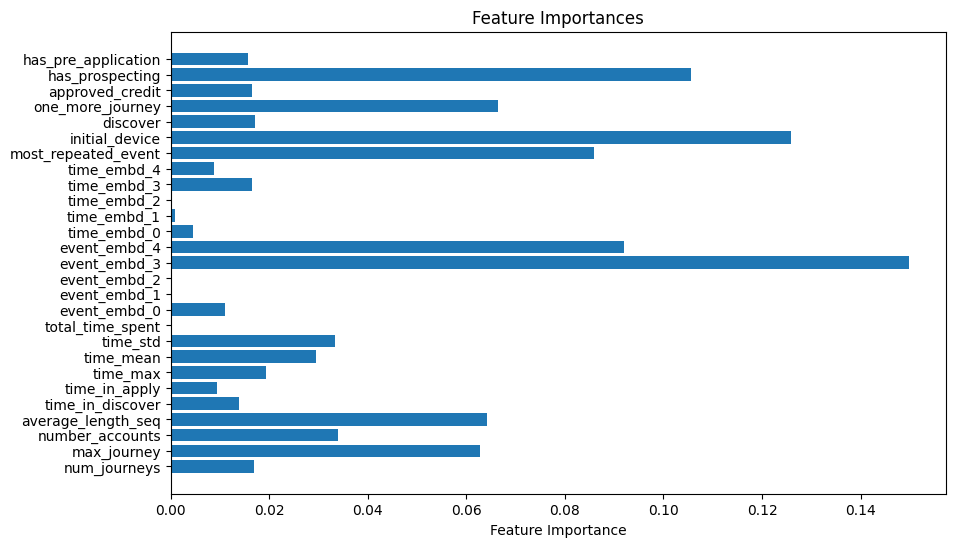

In [39]:
'''x = list(newdfx.drop(columns=['order_ships']).columns)
x = [str(x_i) for x_i in x]'''

plt.figure(figsize=(10, 6))
plt.barh(xgb_clf.feature_names_in_, xgb_clf.feature_importances_)
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.show()

## Imblearning

In [101]:
X_train, X_test, y_train, y_test = train_test_split(ori_df, ori_target, test_size=.2, random_state=2024)

In [9]:
from imblearn.ensemble import BalancedBaggingClassifier

bagging = BalancedBaggingClassifier(n_estimators=100, verbose=1, random_state=2024).fit(X_train, y_train)
bagging_prediction = bagging.predict(X_test)
print(accuracy_score(y_test, bagging_prediction))
print(f1_score(y_test, bagging_prediction))

0.8037384581188161
0.6194384097011492


In [102]:
min_weight = sum(ori_target == 0) / sum(ori_target == 1)
weights = np.where(y_train == 1, min_weight, 1)

dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    # 'n_estimators': 200,
    'max_depth': 10,
    'learning_rate': 0.1,
    'tree_method': 'hist',
    'objective': 'binary:logistic'
}

clf = xgb.train(params, dtrain, 1000, [(dtest, 'test')], early_stopping_rounds=20)
pred = clf.predict(dtest)
prediction = (pred > 0.5).astype(int)

print(f1_score(y_test, prediction))

[0]	test-logloss:0.65000
[1]	test-logloss:0.61445
[2]	test-logloss:0.58537
[3]	test-logloss:0.56098
[4]	test-logloss:0.54062
[5]	test-logloss:0.52349
[6]	test-logloss:0.50897
[7]	test-logloss:0.49658
[8]	test-logloss:0.48602
[9]	test-logloss:0.47675
[10]	test-logloss:0.46891
[11]	test-logloss:0.46209
[12]	test-logloss:0.45617
[13]	test-logloss:0.45103
[14]	test-logloss:0.44619
[15]	test-logloss:0.44214
[16]	test-logloss:0.43850
[17]	test-logloss:0.43538
[18]	test-logloss:0.43227
[19]	test-logloss:0.42985
[20]	test-logloss:0.42746
[21]	test-logloss:0.42557
[22]	test-logloss:0.42350
[23]	test-logloss:0.42196
[24]	test-logloss:0.42046
[25]	test-logloss:0.41900
[26]	test-logloss:0.41744
[27]	test-logloss:0.41641
[28]	test-logloss:0.41528
[29]	test-logloss:0.41444
[30]	test-logloss:0.41330
[31]	test-logloss:0.41236
[32]	test-logloss:0.41176
[33]	test-logloss:0.41106
[34]	test-logloss:0.41056
[35]	test-logloss:0.40973
[36]	test-logloss:0.40912
[37]	test-logloss:0.40866
[38]	test-logloss:0.40

In [103]:
print(classification_report(y_test, prediction))
print(' ')
print(confusion_matrix(y_test, prediction))

              precision    recall  f1-score   support

         0.0       0.95      0.80      0.87    268990
         1.0       0.50      0.83      0.62     63928

    accuracy                           0.81    332918
   macro avg       0.73      0.82      0.75    332918
weighted avg       0.87      0.81      0.82    332918

 
[[215779  53211]
 [ 10824  53104]]


In [ ]:
xgb_cv = xgb.cv(params, dtrain, 1000, nfold=5, metrics={'logloss'}, seed=2024, early_stopping_rounds=10)
print(xgb_cv)

In [49]:
test = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=10, 
    tree_method='hist', 
    objective='binary:logistic',
    scale_pos_weight=min_weight
).fit(X_train, y_train)

pred2 = test.predict(X_test)
print(f1_score(y_test, pred2))

0.6222842336057405


In [50]:
def cross_val(clf, ori_data, ori_target):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)
    scores = cross_val_score(estimator=clf, X=ori_data, y=ori_target, cv=cv, scoring='f1')
    return scores.mean(), scores.std()

cv_mean, cv_std = cross_val(test, ori_df, ori_target)

In [51]:
print(cv_mean)
print(cv_std)

0.6234007728532527
0.000988664859545665


In [52]:
print(confusion_matrix(y_test, pred2))

[[215414  53576]
 [ 10854  53074]]


## PCA and learning

In [99]:
'''numerical_col = ['num_journeys', 'max_journey', 'number_accounts', 'average_length_seq', 'time_in_discover', 'time_in_apply', 
                        'event_id_0', 'event_id_1', 'event_id_2', 'event_id_3', 'event_id_4', 'time_0', 'time_1', 'time_2', 'time_3', 
                        'time_4']
ori_numerical = ori_df[numerical_col]

pca = PCA(n_components=5, random_state=2024)
ori_numerical_reduced = pca.fit_transform(np.array(ori_numerical))
ori_df2 = pd.concat([ori_df.drop(columns=numerical_col).reset_index(drop=True), pd.DataFrame(ori_numerical_reduced)], axis=1)
sum(pca.explained_variance_)'''

pca = PCA(n_components=20, random_state=2024)
ori_df2 = pca.fit_transform(np.array(ori_df))
sum(pca.explained_variance_)

0.7556382378073625

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(ori_df2, ori_target, test_size=.2, random_state=2024)
min_weight = sum(ori_target == 0) / sum(ori_target == 1)
weights = np.where(y_train == 1, min_weight, 1)

dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    # 'n_estimators': 200,
    'max_depth': 10,
    'learning_rate': 0.1,
    'tree_method': 'hist',
    'objective': 'binary:logistic'
}

clf = xgb.train(params, dtrain, 1000, [(dtest, 'test')], early_stopping_rounds=20)
pred = clf.predict(dtest)
prediction = (pred > 0.5).astype(int)

print(f1_score(y_test, prediction))

In [98]:
print(confusion_matrix(y_test, prediction))

[[194308  74682]
 [ 16550  47378]]


## Cluster then train

In [ ]:
def split_train(cluster, target, random_state=2024):
    X_train, X_test, y_train, y_test = train_test_split(cluster, target, train_size=.8, random_state=random_state)
    clf = XGBClassifier(n_estimators=200, 
                        max_depth=10, 
                        learning_rate=0.1, 
                        tree_method='approx',
                        objective='binary:logistic',)

    clf.fit(X_train, y_train)
    xgb_prediction = clf.predict(X_test)

    return xgb_prediction, accuracy_score(y_test, xgb_prediction)
    

def cluster_train(df, n_clusters=2, random_state=2024):
    df = df.apply(scaler)

    # kmeans = KMeans(n_clusters=2, random_state=random_state, init='k-means++', n_init='auto').fit(df[['time_in_discover', 'time_in_apply']])
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, init='k-means++', n_init='auto').fit(df) #.drop(columns='order_ships'))
    # label = kmeans.predict(df[['time_in_discover', 'time_in_apply']])
    label = kmeans.predict(df.drop(columns='order_ships'))

    df_copy = df.copy().reset_index(drop=True)
    df2 = pd.concat([df_copy, pd.Series(label)], axis=1)
    df2.columns = [*df2.columns[:-1], 'cluster_label']

    # return df2

    # cluster 0
    df_cluster0 = df2[df2.cluster_label == 0].drop(columns=['cluster_label']) #, 'order_ships'])
    cluster0_target = df2[df2.cluster_label == 0].order_ships
    cluster0_pred, cluster0_accuracy = split_train(df_cluster0, cluster0_target)

    # cluster 1
    df_cluster1 = df2[df2.cluster_label == 1].drop(columns=['cluster_label']) #, 'order_ships'])
    cluster1_target = df2[df2.cluster_label == 1].order_ships
    cluster1_pred, cluster1_accuracy = split_train(df_cluster1, cluster1_target)

    return cluster0_accuracy, cluster0_pred, cluster1_accuracy, cluster1_pred, \
          (cluster0_accuracy * len(cluster0_pred) + cluster1_accuracy * len(cluster1_pred)) / (len(cluster0_pred) + len(cluster1_pred))